# Basic being Bayesian by backpropagation (BBB)

In [1]:
import nbloader,os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib.slim as slim
from sklearn.utils import shuffle # For batch learning
from demo_correlatedFields import fields
from demo_util import nzr,gpusession,animate_frames
from demo_bbb import bbb
from jupyterthemes import jtplot
jtplot.style()
%matplotlib inline
print ("Packages Loaded")

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Importing Jupyter notebook from [demo_correlatedFields.ipynb]
Importing Jupyter notebook from [demo_util.ipynb]
Importing Jupyter notebook from [demo_bbb.ipynb]
Packages loaded
TF version: 1.3.0
Packages Loaded


Define Bayesian network class

In [2]:
class bayesianNetwork(object):
    def __init__(self,_name='bayesNet',_xdim=2,_ydim=1,_hdims=[32,16],_actv=tf.nn.relu,
                _bn=slim.batch_norm,_sess=None,_VERBOSE=False):
        # Parse inputs
        self.name = _name
        self.xdim = _xdim
        self.ydim = _ydim
        self.hdims = _hdims
        self.actv = _actv
        self.bn = _bn
        self.sess = _sess
        self.VERBOSE = _VERBOSE
        # Number of total params
        self.nParam = self.xdim*self.hdims[0]+self.hdims[-1]*self.ydim+self.hdims[0]+self.ydim
        for hIdx in range(len(self.hdims)-1):
            self.nParam += self.hdims[hIdx]*self.hdims[hIdx+1]+self.hdims[hIdx+1]
        # Initialize graph
        self.init_randomWeights()
        self.construct_graph()
        
    def init_randomWeights(self):
        self.Qweights,self.Qbiases,self.Pweights,self.Pbiases = [],[],[],[]
        for lIdx in range(len(self.hdims)+1):
            if lIdx == 0: # Input to hidden
                _shape = [self.xdim,self.hdims[0]]
            elif lIdx < len(self.hdims): # Hidden to hidden
                _shape = [self.hdims[lIdx-1],self.hdims[lIdx]]
            else: # Hidden to output
                _shape = [self.hdims[-1],self.ydim]
            self.Qweights.append(bbb(_name='Qw%d'%lIdx,_distribution='Gaussian',
                                 _shape=_shape,_trainable=True,_VERBOSE=self.VERBOSE))
            self.Qbiases.append(bbb(_name='Qb%d'%lIdx,_distribution='Gaussian',
                                     _shape=[_shape[1]],_trainable=True,_VERBOSE=self.VERBOSE))
            self.Pweights.append(bbb(_name='Pw%d'%lIdx,_distribution='Gaussian',
                                     _shape=_shape,_trainable=False,_VERBOSE=self.VERBOSE))
            self.Pbiases.append(bbb(_name='Pb%d'%lIdx,_distribution='Gaussian',
                                     _shape=[_shape[1]],_trainable=False,_VERBOSE=self.VERBOSE))
        # Append all global variables
        self.g_vars = []
        for lIdx in range(len(self.hdims)+1):
            self.g_vars += self.Qweights[lIdx].g_vars+self.Qbiases[lIdx].g_vars\
                        + self.Pweights[lIdx].g_vars+self.Pbiases[lIdx].g_vars
    def construct_graph(self):
        # Feeding input and output placeholders
        self.x = tf.placeholder(dtype=tf.float32,shape=[None,self.xdim],name='Input')
        self.y = tf.placeholder(dtype=tf.float32,shape=[None,self.ydim],name='Output')
        self.nx = tf.shape(self.x)[0] # number of inputs
        self.x_rsh = tf.reshape(self.x,shape=[-1,self.xdim,1])
        # Construct stochastic forward path         
        self.net_stochastic = self.x_rsh
        self.logProb_Qtheta,self.logProb_Ptheta = 0,0
        for lIdx in range(len(self.hdims)+1):
            _Qw_sampler = self.Qweights[lIdx].sampler # [None x dim(weight)]
            _Qb_sampler = self.Qbiases[lIdx].sampler # [None x dim(weight)]
            # 
            self.logProb_Qtheta += self.Qweights[lIdx].get_logProb(_Qw_sampler)
            self.logProb_Qtheta += self.Qbiases[lIdx].get_logProb(_Qb_sampler)
            self.logProb_Ptheta += self.Pweights[lIdx].get_logProb(_Qw_sampler)
            self.logProb_Ptheta += self.Pbiases[lIdx].get_logProb(_Qb_sampler)
            #
            _w_rsh = tf.reshape(_Qw_sampler,shape=[-1,self.Qweights[lIdx].shape[1],self.Qweights[lIdx].shape[0]])
            _b_rsh = tf.reshape(_Qb_sampler,shape=[-1,self.Qbiases[lIdx].shape[0],1])
            self.net_stochastic = tf.matmul(_w_rsh,self.net_stochastic)+_b_rsh # [None x self.hdims[0] x 1]
            if lIdx == len(self.hdims):
                self.net_stochastic = self.net_stochastic
            else:
                self.net_stochastic = self.actv(self.net_stochastic)
        # Construct deterministic forward path
        self.net_deterministic = self.x_rsh
        for lIdx in range(len(self.hdims)+1):
            _Qw_representative = self.Qweights[lIdx].representative # [None x dim(weight)]
            _Qb_representative = self.Qbiases[lIdx].representative # [None x dim(weight)]
            _w_rsh = tf.reshape(_Qw_representative,shape=[-1,self.Qweights[lIdx].shape[1],self.Qweights[lIdx].shape[0]])
            _b_rsh = tf.reshape(_Qb_representative,shape=[-1,self.Qbiases[lIdx].shape[0],1])
            self.net_deterministic = tf.matmul(_w_rsh,self.net_deterministic)+_b_rsh # [None x self.hdims[0] x 1]
            if lIdx == len(self.hdims):
                self.net_deterministic = self.net_deterministic
            else:
                self.net_deterministic = self.actv(self.net_deterministic)
        # Normalize log P(W) and log Q(W)
        self.logProb_Qtheta,self.logProb_Ptheta = self.logProb_Qtheta/self.nParam,self.logProb_Ptheta/self.nParam
        # Define loss function 
        self.out = tf.reshape(self.net_stochastic,[-1,self.ydim])
        self.err_sq = tf.pow(self.out-self.y,2)
        self.err_sq_rdc = tf.reduce_mean(self.err_sq,axis=1)
        
        nllRate,lqRate,nlpRate = 1,0.01,0.01
        self.loss_nll = nllRate*tf.reduce_mean(self.err_sq_rdc) # negative log likelihood
        self.loss_lq = lqRate*tf.reduce_mean(self.logProb_Qtheta) # log Q
        self.loss_nlp = -nlpRate*tf.reduce_mean(self.logProb_Ptheta) # negative log prior
        
        self.loss_total = nllRate*self.loss_nll + self.loss_lq + self.loss_nlp
        # Define optimizer
        self.lr_adam = tf.placeholder(dtype=tf.float32,shape=[],name='lr_adam')
        self.lr_sgd = tf.placeholder(dtype=tf.float32,shape=[],name='lr_sgd')
        self.optm_adam = tf.train.AdamOptimizer(
            learning_rate=self.lr_adam,beta1=0.8,beta2=0.99,epsilon=1e-6)\
            .minimize(self.loss_total)
        self.optm_sgd = tf.train.GradientDescentOptimizer(
            learning_rate=self.lr_sgd).minimize(self.loss_total)
        
    # Stochastic forward path
    def stochastic_forwardPath(self,_x):
        nData = _x.shape[0]
        # Feed input
        feeds = {self.x:_x}
        # Feed nData to all weights
        for hIdx in range(len(self.hdims)+1):
            feeds[self.Qweights[hIdx].nSample] = nData
            feeds[self.Qbiases[hIdx].nSample] = nData
        return self.sess.run(self.net_stochastic,feed_dict=feeds)
    
    # Deterministic forward path
    def deterministic_forwardPath(self,_x):
        nData = _x.shape[0]
        # Feed input
        feeds = {self.x:_x}
        # Feed nData to all weights
        for hIdx in range(len(self.hdims)+1):
            feeds[self.Qweights[hIdx].nSample] = nData
            feeds[self.Qbiases[hIdx].nSample] = nData
        return self.sess.run(self.net_deterministic,feed_dict=feeds)
    
    # Train 
    def train(self,_x,_y,_maxEpoch=1000,_batchSize=128,_printPeriod=100,_plotPeriod=100,
             _lr_adam=1e-4,_lr_sgd=1e-5):
        # Number of training data
        nData = _x.shape[0] 
        # mini-batch training
        maxIter = max(nData // _batchSize, 1)
        for epoch in range(_maxEpoch): # For every epoch 
            
            _x,_y = shuffle(_x,_y) # Shuffle 
            trainRate = (float)(epoch)/(float)(_maxEpoch)
            for i in range(maxIter):
                xBatch = _x[i*_batchSize:(i+1)*_batchSize,:]
                yBatch = _y[i*_batchSize:(i+1)*_batchSize,:]
                nBatch = xBatch.shape[0]
                # Feed input 
                feeds = {self.x:xBatch,self.y:yBatch,
                         self.lr_adam:_lr_adam,self.lr_sgd:_lr_sgd}
                for hIdx in range(len(self.hdims)+1):
                    feeds[self.Qweights[hIdx].nSample] = nBatch
                    feeds[self.Qbiases[hIdx].nSample] = nBatch
                # Run train
                if trainRate < 1.0: _optm = self.optm_adam
                else: _optm = self.optm_sgd
                _,_loss,_nll,_lq,_nlp = self.sess.run([_optm,self.loss_total,self.loss_nll,
                                                 self.loss_lq,self.loss_nlp],
                                                feed_dict=feeds)
            # Print loss
            if (epoch%_printPeriod)==0:
                print("[%.1f%%][%04d/%d] loss=[-log(D|W)]+[logQ(W)]+[-logP(W)] %.3f=%.3f+%.3f+%.3f"%
                      (trainRate*100.0,epoch,_maxEpoch,_loss,_nll,_lq,_nlp))
                
    # Save 
    def save(self,_savename=None):
        """ Save name """
        if _savename==None:
            _savename='net/net_%s.npz'%(self.name)
        """ Get global variables """
        self.g_wnames,self.g_wvals,self.g_wshapes = [],[],[]
        for i in range(len(self.g_vars)):
            curr_wname = self.g_vars[i].name
            curr_wvar  = [v for v in tf.global_variables() if v.name==curr_wname][0]
            curr_wval  = self.sess.run(curr_wvar)
            curr_wval_sqz  = curr_wval.squeeze()
            self.g_wnames.append(curr_wname)
            self.g_wvals.append(curr_wval_sqz)
            self.g_wshapes.append(curr_wval.shape)
        """ Save """
        np.savez(_savename,g_wnames=self.g_wnames,g_wvals=self.g_wvals,g_wshapes=self.g_wshapes)
        print ("[%s] Saved. Size is [%.4f]MB" % 
               (_savename,os.path.getsize(_savename)/1000./1000.))
        
    # Restore
    def restore(self,_loadname=None):
        if _loadname==None:
            _loadname='net/net_%s.npz'%(self.name)
        l = np.load(_loadname)
        g_wnames = l['g_wnames']
        g_wvals  = l['g_wvals']
        g_wshapes = l['g_wshapes']
        for widx,wname in enumerate(g_wnames):
            curr_wvar  = [v for v in tf.global_variables() if v.name==wname][0]
            self.sess.run(tf.assign(curr_wvar,g_wvals[widx].reshape(g_wshapes[widx])))
        print ("Weight restored from [%s]" % (_loadname))
print ("Class defined")

Class defined


Make correlated field

In [3]:
rSeed = 1
F = fields(_name='fields',_VERBOSE=False,_axisInfo=np.array([0,10,0,10]),
           _resFineInfo=np.array([100,100]),_resCoarseInfo=np.array([20,20]),_nField=10)
levs = np.array([[1,1,1,1,0,0,0,-1,-1,-1]]).astype(np.float).T
hyp = {'gain':1,'len':1/2.,'s2w':1e-10}
F.genCorrelatedFields(_levs=levs,_rseed=rSeed,_hyp=hyp)
F.getMeasurements(_nMeas=200,_rseed=rSeed)
F.getAccumulatedMeas()
# Use the first field
firstField = F.fields[0]
# firstField.plotField(_figsize=(7,7),_title='Original Field',_PLOT_COARSE=False,_PLOT_MEAS=True)
X,Y = firstField.xyFineMeas,firstField.zFineMeas
print 'X.shape:',X.shape,'Y.shape:',Y.shape

X.shape: (200, 2) Y.shape: (200, 1)


Instantiate 'bayesianNetwork' object

In [4]:
sess = gpusession()
BN = bayesianNetwork(_xdim=2,_ydim=1,_hdims=[32,32],_actv=tf.nn.tanh,
                     _bn=None,_sess=sess,_VERBOSE=False)
print ("Bayesian network instantiated.")

Bayesian network instantiated.


Train Bayesian neural network

In [5]:
sess.run(tf.global_variables_initializer())
maxEpoch = 10000
BN.train(X,Y,_maxEpoch=maxEpoch,_batchSize=256,_printPeriod=maxEpoch//20,_plotPeriod=10,
         _lr_adam=1e-4,_lr_sgd=1e-6)
print ("Train done.")

[0.0%][0000/10000] loss=[-log(D|W)]+[logQ(W)]+[-logP(W)] 1.796=1.751+0.039+0.006
[5.0%][0500/10000] loss=[-log(D|W)]+[logQ(W)]+[-logP(W)] 0.471=0.426+0.039+0.006
[10.0%][1000/10000] loss=[-log(D|W)]+[logQ(W)]+[-logP(W)] 0.354=0.309+0.039+0.006
[15.0%][1500/10000] loss=[-log(D|W)]+[logQ(W)]+[-logP(W)] 0.312=0.267+0.039+0.006
[20.0%][2000/10000] loss=[-log(D|W)]+[logQ(W)]+[-logP(W)] 0.293=0.248+0.039+0.006
[25.0%][2500/10000] loss=[-log(D|W)]+[logQ(W)]+[-logP(W)] 0.282=0.237+0.039+0.006
[30.0%][3000/10000] loss=[-log(D|W)]+[logQ(W)]+[-logP(W)] 0.272=0.228+0.039+0.006
[35.0%][3500/10000] loss=[-log(D|W)]+[logQ(W)]+[-logP(W)] 0.260=0.215+0.039+0.006
[40.0%][4000/10000] loss=[-log(D|W)]+[logQ(W)]+[-logP(W)] 0.262=0.217+0.039+0.006
[45.0%][4500/10000] loss=[-log(D|W)]+[logQ(W)]+[-logP(W)] 0.254=0.209+0.039+0.006
[50.0%][5000/10000] loss=[-log(D|W)]+[logQ(W)]+[-logP(W)] 0.237=0.192+0.039+0.006
[55.0%][5500/10000] loss=[-log(D|W)]+[logQ(W)]+[-logP(W)] 0.246=0.201+0.039+0.006
[60.0%][6000/10000

Reconstruct field

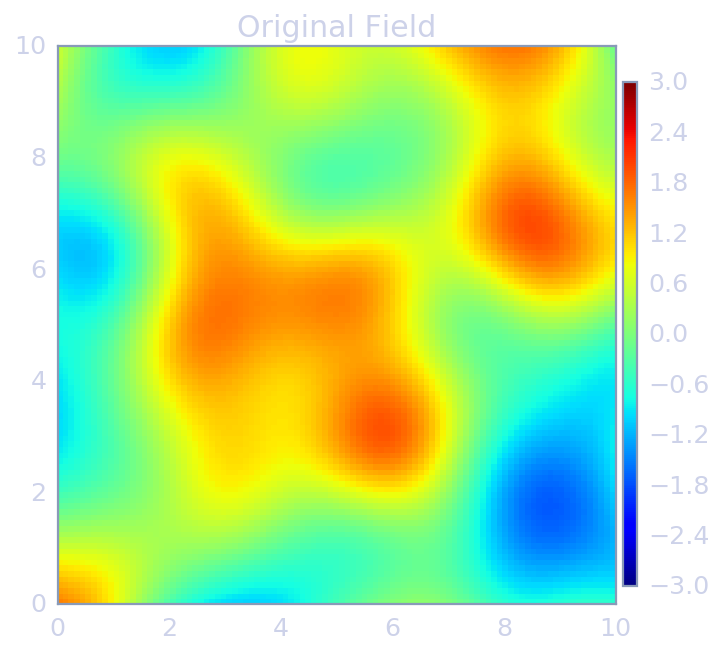

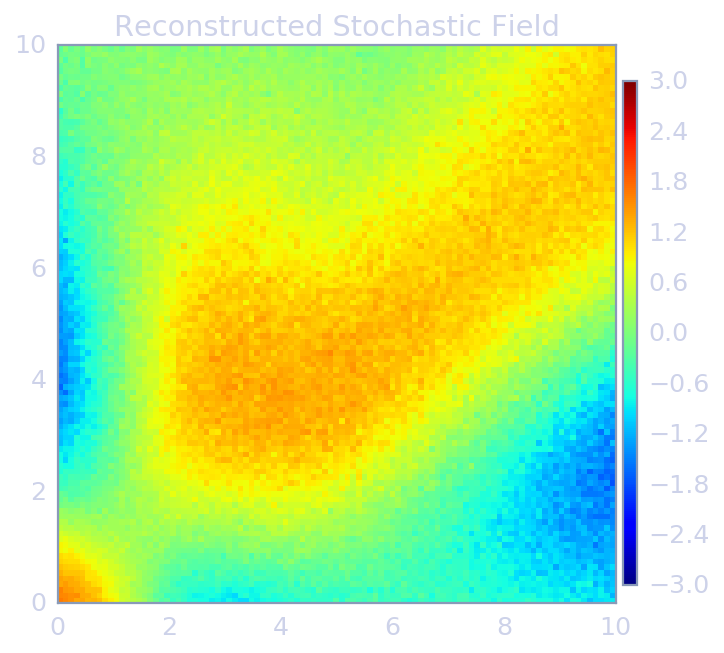

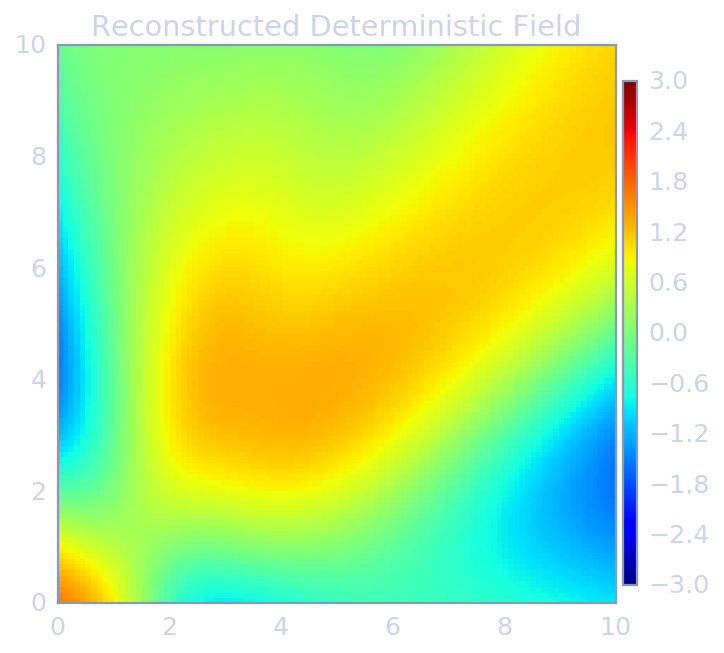

In [6]:
# Plot original field
firstField.plotField(_figsize=(5,5),_title='Original Field',
                     _PLOT_COARSE=False,_PLOT_MEAS=False)
# Plot stochastic reconstructed field
fig_s = plt.figure(figsize=(5,5))
zRegResStochastic = BN.stochastic_forwardPath(firstField.xyFine)
p = plt.pcolormesh(firstField.xFineGrid,firstField.yFineGrid,
                 zRegResStochastic.reshape(firstField.yFineRes,firstField.xFineRes).T,
                 vmin=-3,vmax=3)
plt.axis('equal')
plt.title('Reconstructed Stochastic Field')
cbar_ax = fig_s.add_axes([0.91, 0.15, 0.02, 0.7])
fig_s.colorbar(p, cax=cbar_ax)
plt.show()
# Plot deterministic reconstructed field
fig_d = plt.figure(figsize=(5,5))
zRegResDeterministic = BN.deterministic_forwardPath(firstField.xyFine)
p = plt.pcolormesh(firstField.xFineGrid,firstField.yFineGrid,
                 zRegResDeterministic.reshape(firstField.yFineRes,firstField.xFineRes).T,
                 vmin=-3,vmax=3)
plt.axis('equal')
plt.title('Reconstructed Deterministic Field')
cbar_ax = fig_d.add_axes([0.91, 0.15, 0.02, 0.7])
fig_d.colorbar(p, cax=cbar_ax)
plt.show()

Save => Init => Restore => Re-plot to check

[net/net_bayesNet.npz] Saved. Size is [0.0117]MB
Weight restored from [net/net_bayesNet.npz]


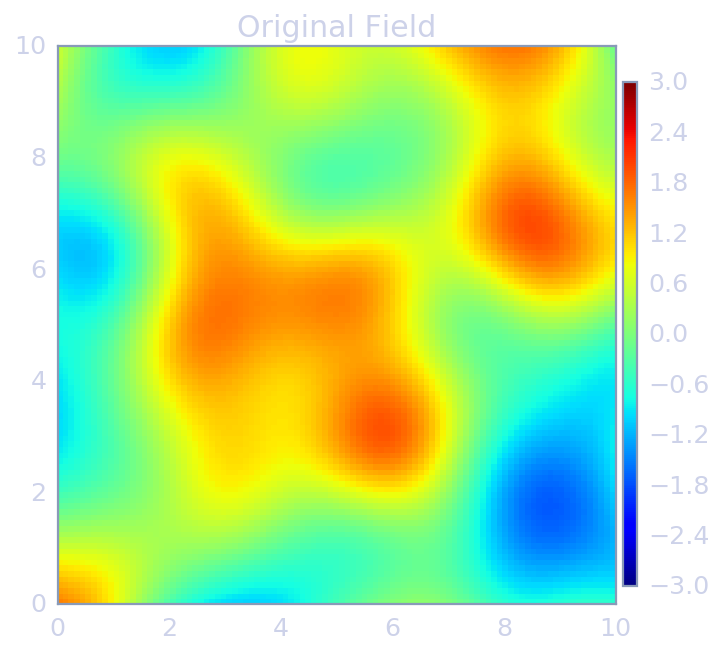

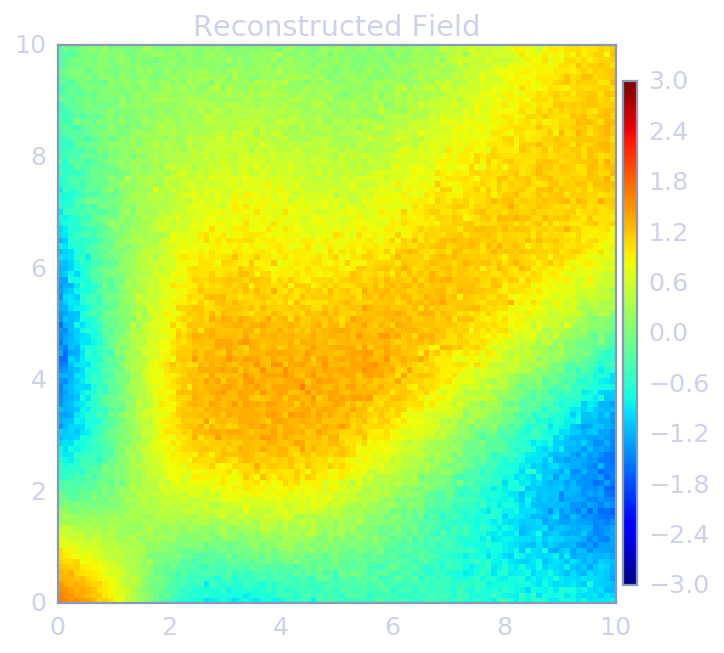

In [7]:
# Save
BN.save()
# Initialize 
sess.run(tf.global_variables_initializer())
# Restore
_loadname='net/net_%s.npz'%(BN.name)
l = np.load(_loadname)
g_wnames,g_wvals,g_wshapes = l['g_wnames'],l['g_wvals'],l['g_wshapes']
for widx,wname in enumerate(g_wnames):
    curr_wvar  = [v for v in tf.global_variables() if v.name==wname][0]
    BN.sess.run(tf.assign(curr_wvar,g_wvals[widx].reshape(g_wshapes[widx])))
print ("Weight restored from [%s]" % (_loadname))
# Plot original field
firstField.plotField(_figsize=(5,5),_title='Original Field',
                     _PLOT_COARSE=False,_PLOT_MEAS=False)
# Plot reconstructed field
fig = plt.figure(figsize=(5,5))
zRegRes = BN.stochastic_forwardPath(firstField.xyFine)
p = plt.pcolormesh(firstField.xFineGrid,firstField.yFineGrid,
                 zRegRes.reshape(firstField.yFineRes,firstField.xFineRes).T,
                 vmin=-3,vmax=3)
plt.axis('equal')
plt.title('Reconstructed Field')
# Colorbar
cbar_ax = fig.add_axes([0.91, 0.15, 0.02, 0.7])
fig.colorbar(p, cax=cbar_ax)

Animate


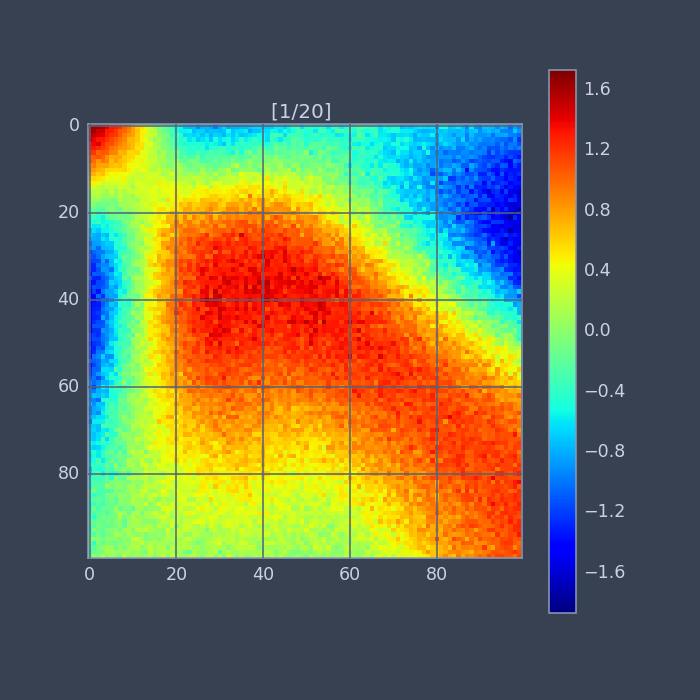
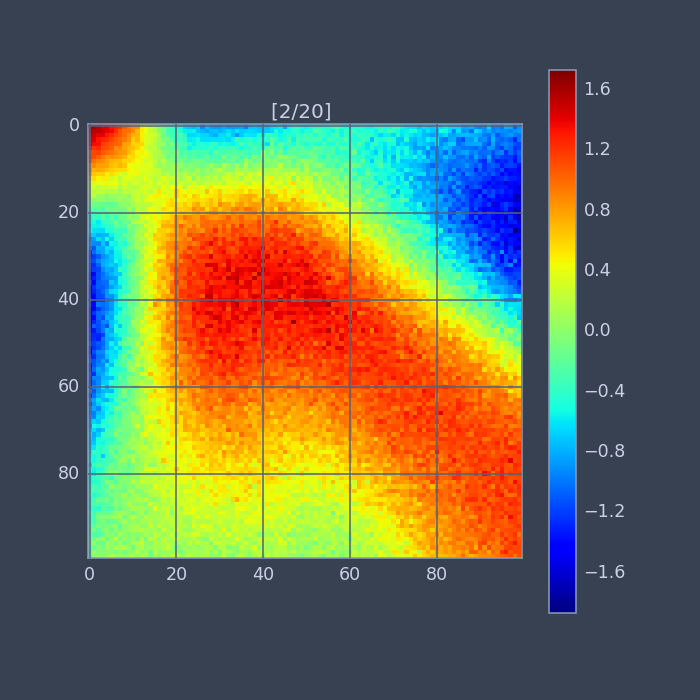
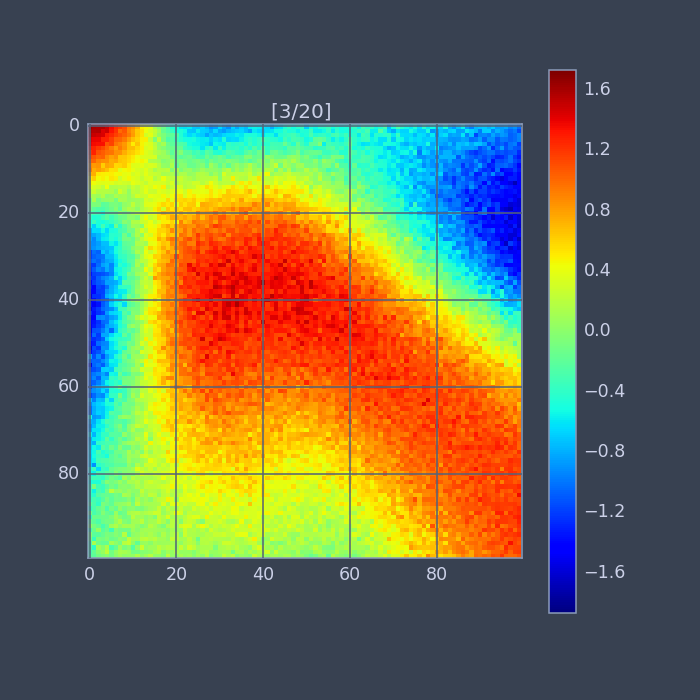
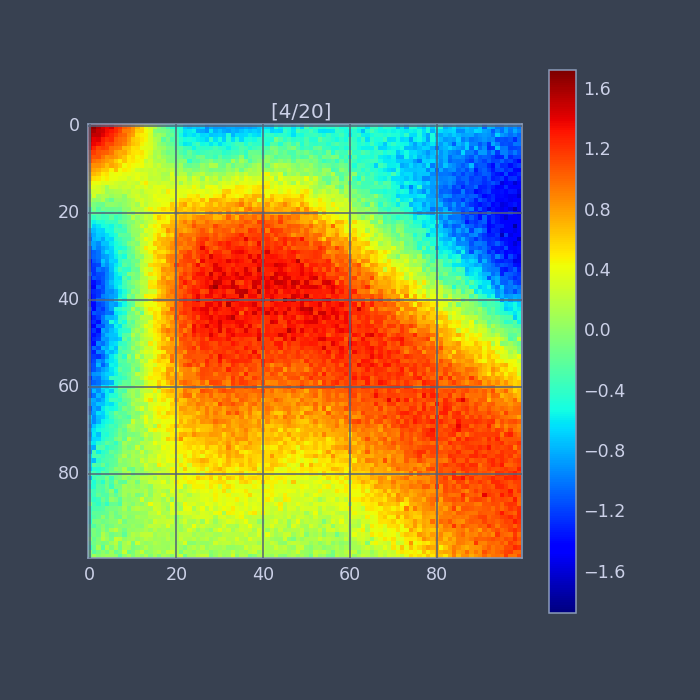
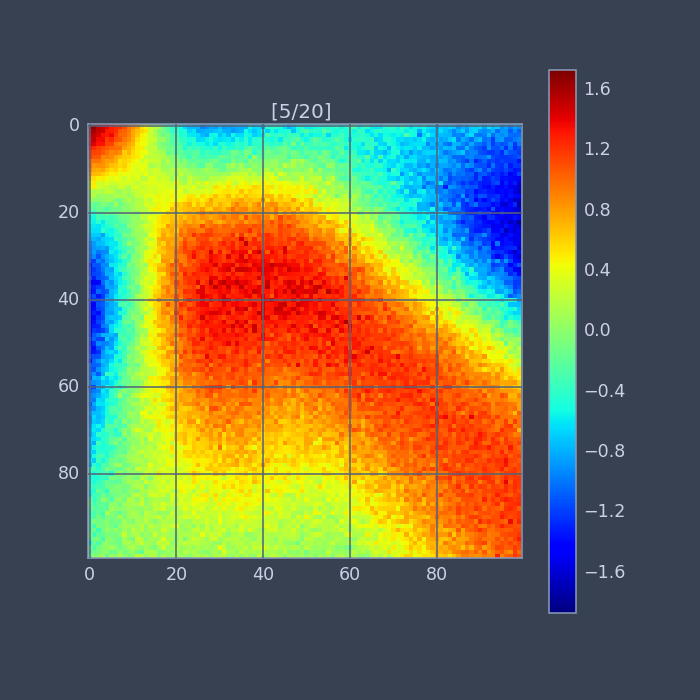
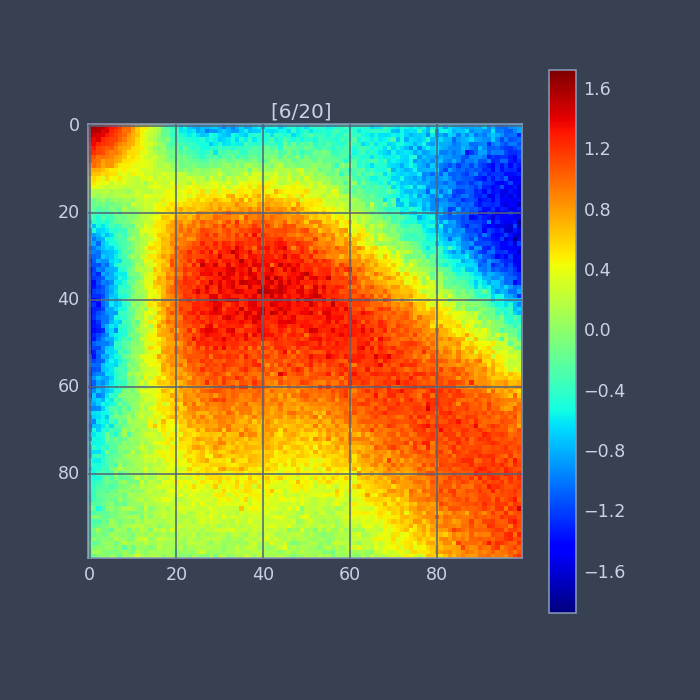
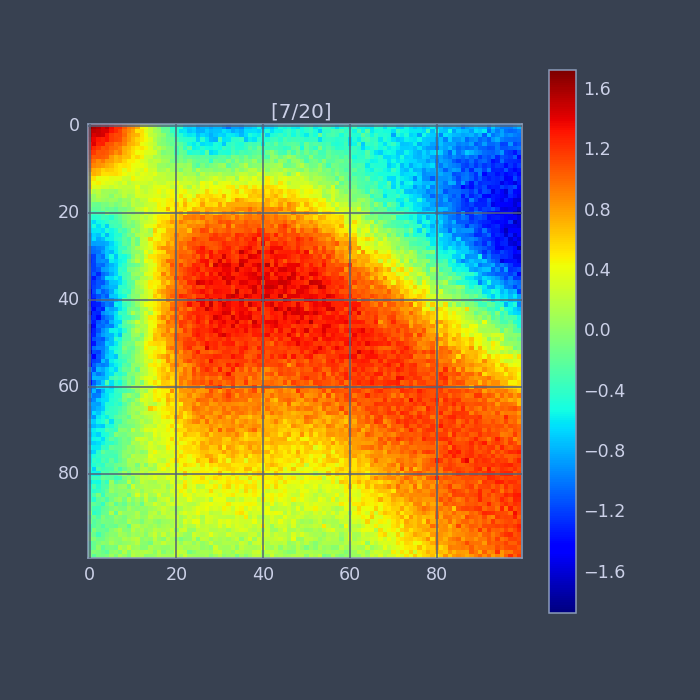
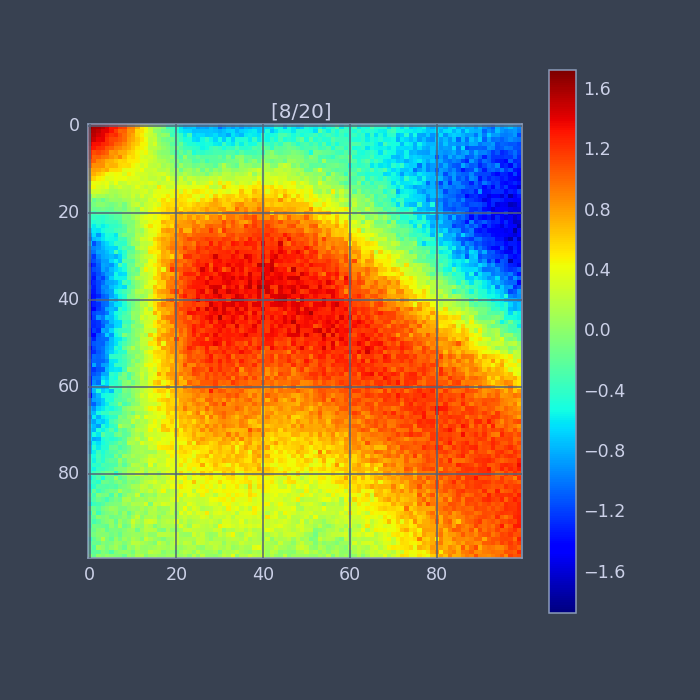
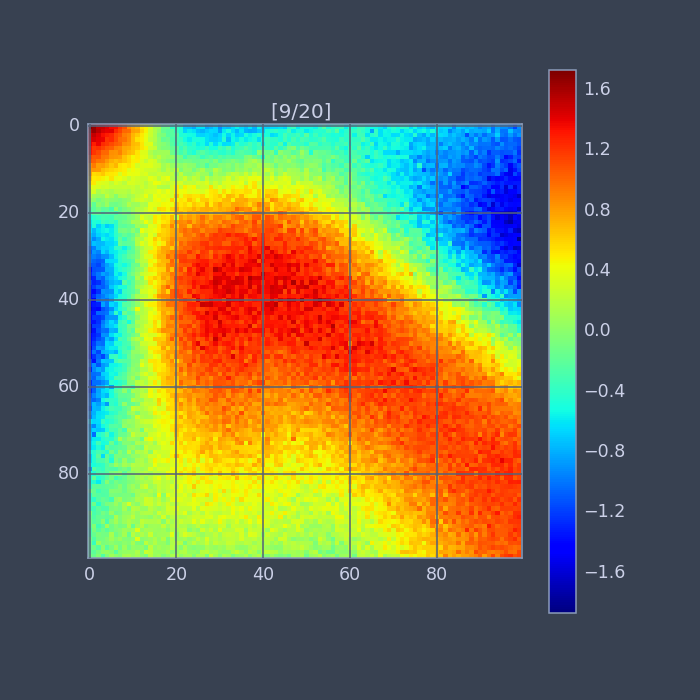
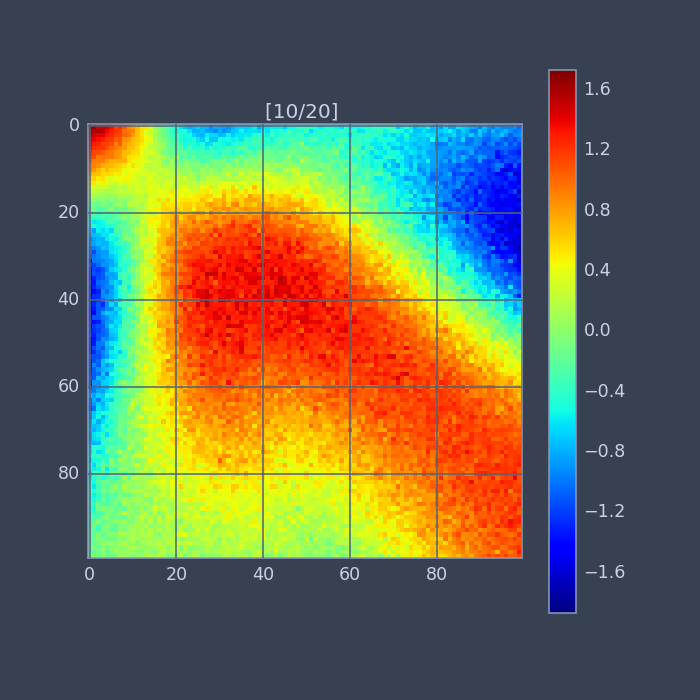
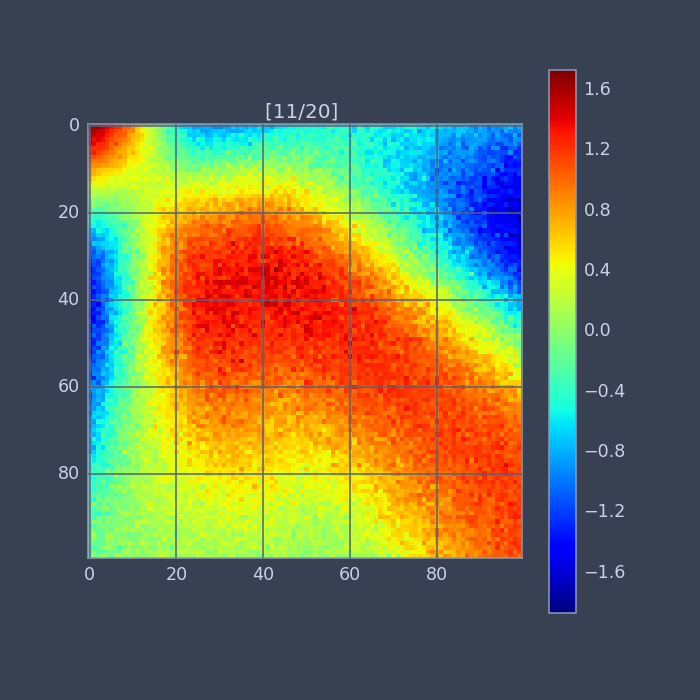
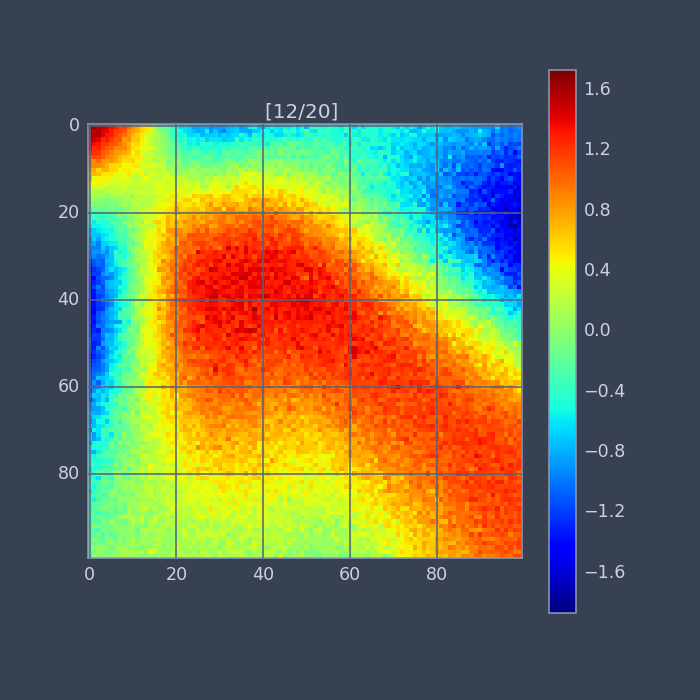
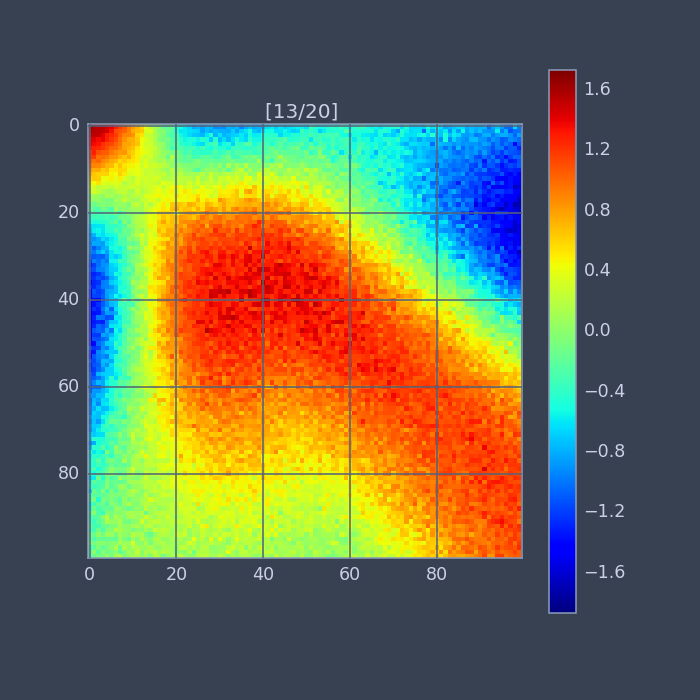
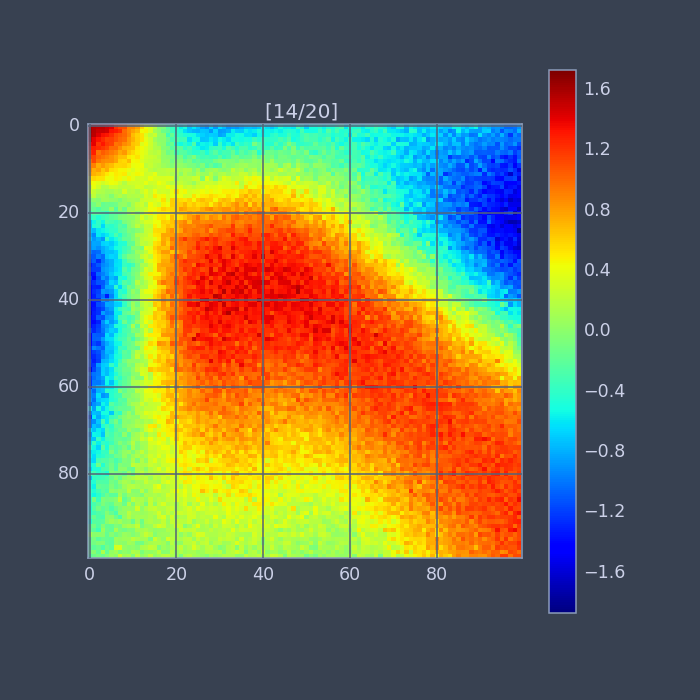
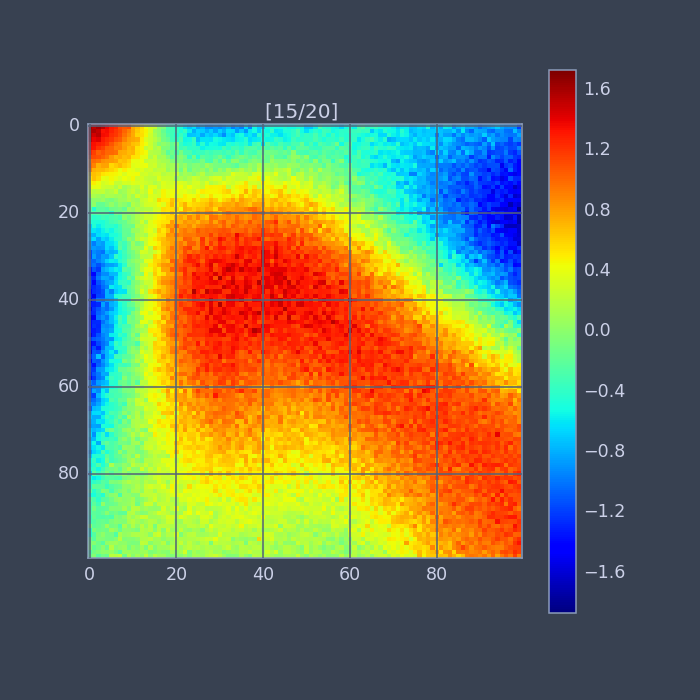
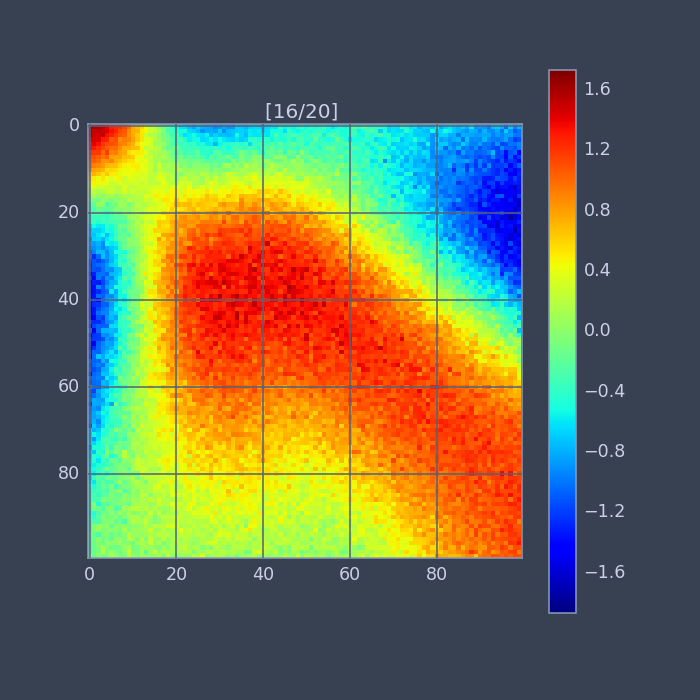
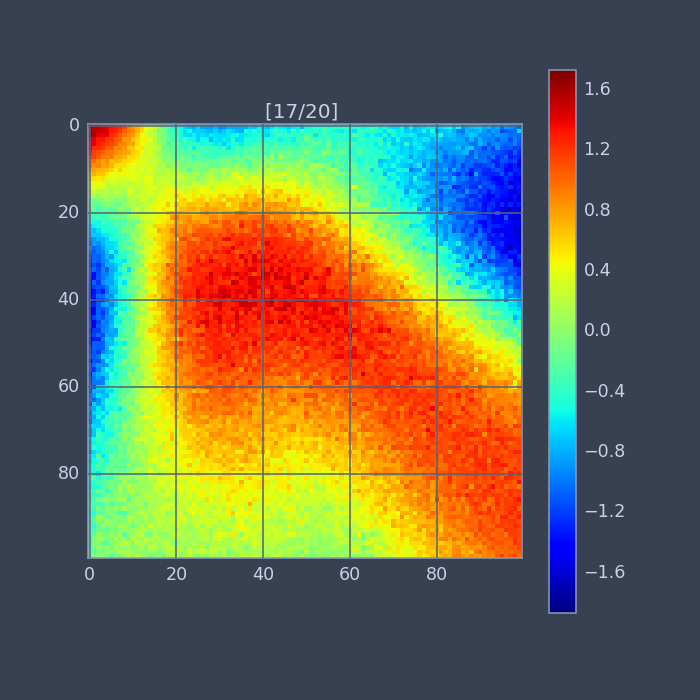
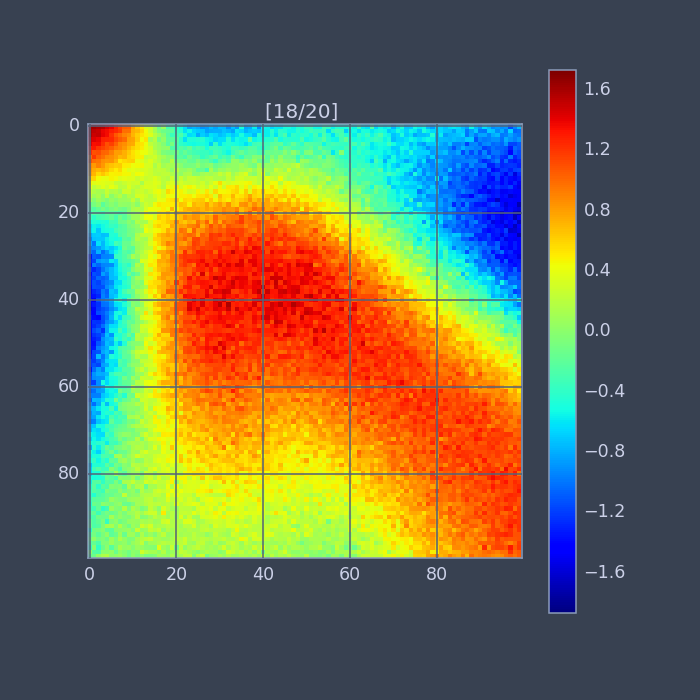
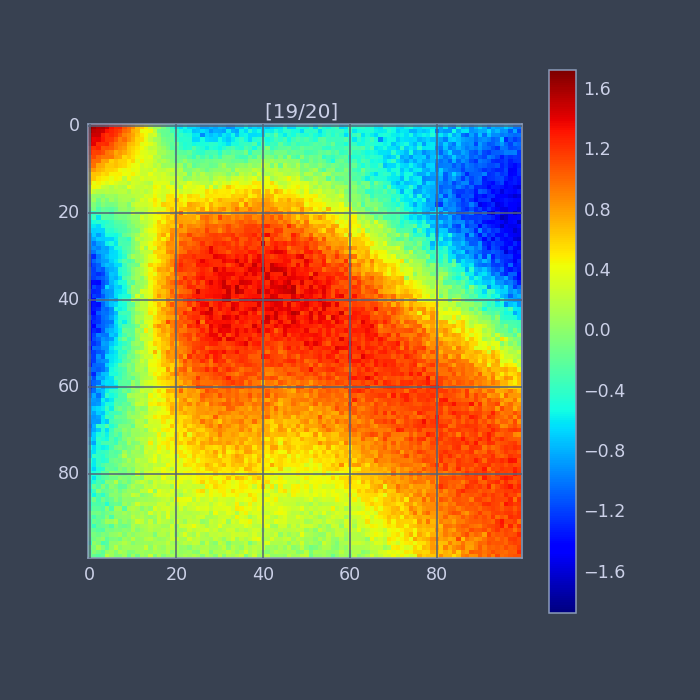
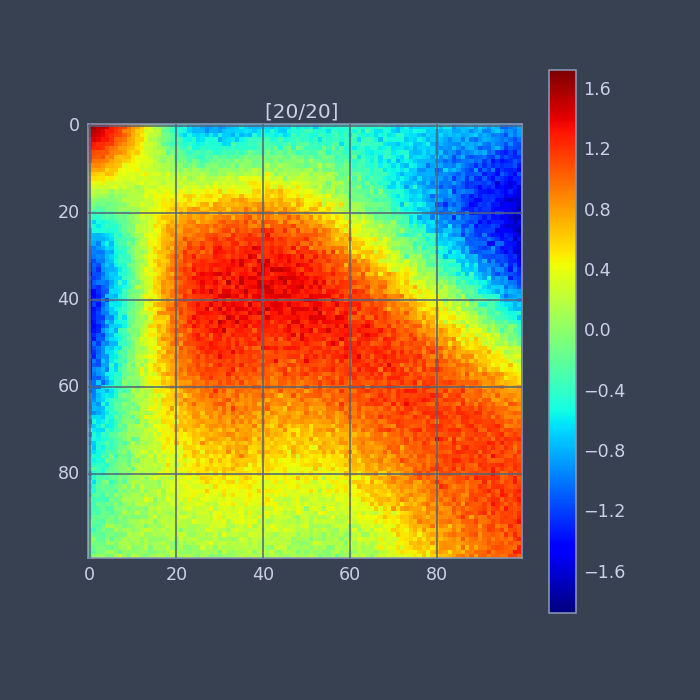

In [8]:
nFrame = 20
frames = []
for i in range(nFrame):
    zRegRes = BN.stochastic_forwardPath(firstField.xyFine).\
        reshape(firstField.yFineRes,firstField.xFineRes).T
    frames.append(zRegRes)
# Animate
animate_frames(_frames=frames,_figsize=(7,7))